In [1]:
from data_pre_processing.fetch_data import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
X_train, Y_train = get_X_Y_train()


## Average number of missing values per user

mean: 15.2414
std:  11.107543654652005


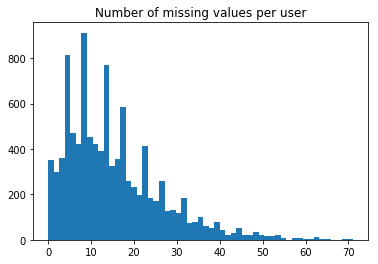

In [3]:
all_users_ratings = X_train[:,1,:]
number_of_missing_values_per_user = np.sum(np.isnan(all_users_ratings), axis=1)

print("mean:" , np.mean(number_of_missing_values_per_user))
print("std: ", np.std(number_of_missing_values_per_user))

plt.hist(number_of_missing_values_per_user, bins='auto')  # arguments are passed to np.histogram
plt.title("Number of missing values per user")
plt.show()


## Number of missing instances per movie

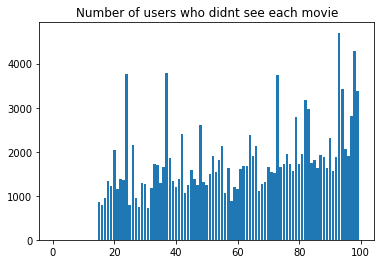

1543.0
1539.5353535353536
969.6442158419677


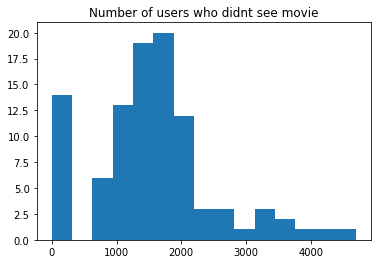

In [4]:
number_of_users_who_didnt_see = np.sum(np.isnan(all_users_ratings), axis=0)
plt.bar(np.arange(1,100), number_of_users_who_didnt_see)
plt.title("Number of users who didnt see each movie")
plt.show()

print(np.median(number_of_users_who_didnt_see))
print(np.mean(number_of_users_who_didnt_see))
print(np.std(number_of_users_who_didnt_see))

plt.hist(number_of_users_who_didnt_see, bins='auto')  # arguments are passed to np.histogram
plt.title("Number of users who didnt see movie")
plt.show()

## PCA

In [5]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

### With Mean Per User Fill

In [6]:
from data_pre_processing.fill_missing_values import fill_ratings_with_mean_per_user
X_filled, _ = fill_ratings_with_mean_per_user(X_train)
all_users_ratings_filled = X_filled[:,1,:] # only ratings

scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(all_users_ratings_filled)

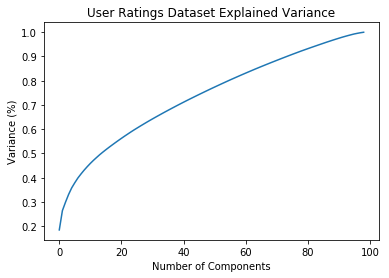

In [7]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(data_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('User Ratings Dataset Explained Variance')
plt.show()

In [8]:
np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.9)

74

### Remove Bad Movies

2
(10000, 99)
(10000, 97)


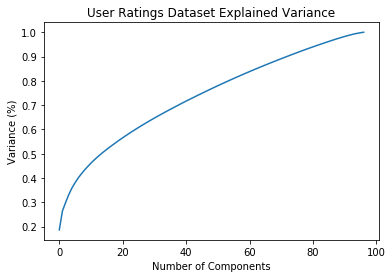

72

In [9]:
from data_pre_processing.fill_missing_values import fill_ratings_with_mean_per_user

bad_movie_indexes = np.argwhere(number_of_users_who_didnt_see > 4000).squeeze()

print(len(bad_movie_indexes))

X_filled, _ = fill_ratings_with_mean_per_user(X_train)
all_users_ratings_filled = X_filled[:,1,:] # only ratings
print(all_users_ratings_filled.shape)

all_users_ratings_filled = np.delete(all_users_ratings_filled, bad_movie_indexes, axis = 1)
print(all_users_ratings_filled.shape)

scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(all_users_ratings_filled)

#Fitting the PCA algorithm with our Data
pca = PCA().fit(data_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('User Ratings Dataset Explained Variance')
plt.show()

np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.9)

## Correlation between dates of rating and rating value

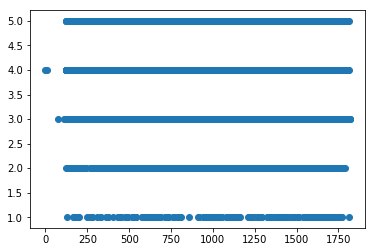

In [10]:
plt.scatter(X_train[:,2,0] - get_output_movie_date(), Y_train)
plt.show()

### moving average of ratings by time it took to watch the movie

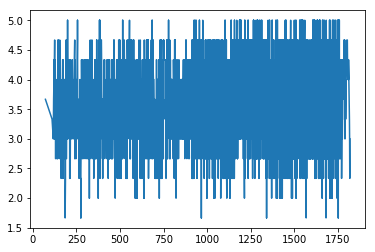

In [11]:
X_train, Y_train = get_X_Y_train()
dates = X_train[:,2,0]
ratings = Y_train

time_after_movie_release = dates - get_output_movie_date()

sort_indexes = np.argsort(time_after_movie_release)
time_after_movie_release = time_after_movie_release[sort_indexes]
ratings = ratings[sort_indexes]

def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

ratings_ma = movingaverage(ratings, 3)

plt.plot(time_after_movie_release[len(time_after_movie_release)-len(ratings_ma):],ratings_ma)
plt.show()

In [12]:
X_train, Y_train = get_X_Y_train()
target_movie_dates = X_train[:,2,0]
ratings = Y_train

target_movie_time_after_release = target_movie_dates - get_output_movie_date()
assert len(target_movie_time_after_release) == 10000

all_users_dates = X_train[:,0,:]
release_date_of_all = np.nanmin(all_users_dates, axis=0)
assert len(release_date_of_all) == 99

time_after_release = all_users_dates - release_date_of_all
no_nan_time_after_release = [a[~np.isnan(a)] for a in time_after_release]


average_time_to_see_movie = [ np.mean(a) for a in no_nan_time_after_release]
assert len(average_time_to_see_movie) == 10000

delt = target_movie_time_after_release - average_time_to_see_movie



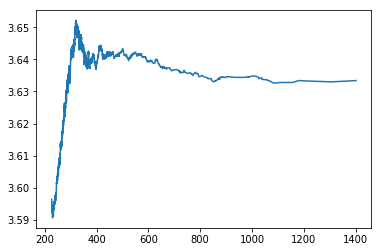

In [22]:
sort_indexes = np.argsort(delt)
delt = delt[sort_indexes]
ratings = ratings[sort_indexes]

ratings_ma = movingaverage(ratings, 5000)

plt.plot(delt[len(delt)-len(ratings_ma):],ratings_ma)
plt.show()

In [14]:
release_date = np.min(X_train[:,2,0])
time_after_release = (X_train[:,2,0] - release_date).reshape(X_train.shape[0], -1)

In [15]:
from regressors.fill_with_mean_per_user_clean_movies_regressor import FillWithMeanPerUserCleanMoviesRegressor
def _rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))


X_train, Y_train = get_X_Y_train()
reg = FillWithMeanPerUserCleanMoviesRegressor()
reg.fit(X_train, Y_train)
_rmse(reg.predict(X_train), Y_train)

0.7504241577632074

In [16]:
from regressors.all_features_regressor import AllFeaturesRegressor
def _rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))


X_train, Y_train = get_X_Y_train()
reg = AllFeaturesRegressor(max_depth=8, n_estimators = 300)
reg.fit(X_train, Y_train)
_rmse(reg.predict(X_train), Y_train)

TypeError: __init__() got an unexpected keyword argument 'max_depth'

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

features = AllFeaturesRegressor()._prepare_X(X_train)
print(features[0])

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = 1, verbose = 2)

grid_search.fit(features, Y_train)
grid_search.best_params_

In [ ]:
# {'bootstrap': True,
#  'max_depth': 100,
#  'max_features': 3,
#  'min_samples_leaf': 3,
#  'min_samples_split': 8,
#  'n_estimators': 1000}